# Projet ML2: US elections
## Auteur: Sylvie Jarjayes
## Cadre: DU Data Analytics de la Sorbonne
#### Dans ce notebook, il s'agit de prédire les résultats des élections américaines de 2020 à partir de données démographiques et sociologiques.

# 1.Données des élections 2020:
#### import, création target, premières stats, création features: état + longitude et latitude

## 1.1 Import Données et création target

In [240]:
#!pip install mlxtend

In [241]:
#!pip install xgboost

In [243]:
#!pip install dtreeviz

In [122]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px


from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, RobustScaler, MaxAbsScaler
from sklearn.preprocessing import PolynomialFeatures

from sklearn.preprocessing import PowerTransformer

from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_selector

from sklearn.svm import SVC
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import GridSearchCV


from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet

from sklearn.metrics import f1_score, recall_score, precision_score, make_scorer

from mlxtend.plotting import plot_decision_regions

from sklearn.metrics import f1_score, make_scorer

from sklearn.ensemble import RandomForestClassifier


from sklearn.model_selection import (
    train_test_split, 
    GridSearchCV,
    cross_val_predict
)

import xgboost as xgb
from sklearn import metrics

import sklearn as sk

from sklearn.ensemble import RandomForestClassifier

from sklearn.tree import export_graphviz

from sklearn import tree
from dtreeviz.trees import dtreeviz 

from sklearn.ensemble import StackingClassifier

In [2]:
# Propriétés des graphiques

from matplotlib import style
#print(plt.style.available)

plt.style.use('seaborn')

In [3]:
# Propriétés d'affichage
pd.options.display.max_columns = None
pd.options.display.max_rows = None

In [3]:
# Vérification des fichiers présents dans le répertoire courant
os.listdir()

['.ipynb_checkpoints',
 '.~lock.Education.xls#',
 '.~lock.PopulationEstimates.xls#',
 '.~lock.PovertyEstimates.xls#',
 '.~lock.state_code.csv#',
 '05_support_vector_machines.ipynb.txt',
 '2020_US_County_Level_Presidential_Results.csv',
 'county_statistics.csv',
 'Education.xls',
 'PopulationEstimates.xls',
 'PovertyEstimates.xls',
 'projet_ml2_us_elections.ipynb',
 'projet_ml2_us_elections_15102022.ipynb',
 'projet_ml2_us_elections_16102022.ipynb',
 'projet_ml2_us_elections_v2.ipynb',
 'projet_ml2_us_elections_v3.ipynb',
 'SDA - Projet Classification.pdf',
 'state_code.csv',
 'Untitled.ipynb',
 'us_county_latlng.csv']

In [4]:
# Import des données des élections 2020
data = pd.read_csv('2020_US_County_Level_Presidential_Results.csv')
# Visu
data.head()

state_name  county_fips     county_name  votes_gop  votes_dem  total_votes  \
0    Alabama         1001  Autauga County      19838       7503        27770   
1    Alabama         1003  Baldwin County      83544      24578       109679   
2    Alabama         1005  Barbour County       5622       4816        10518   
3    Alabama         1007     Bibb County       7525       1986         9595   
4    Alabama         1009   Blount County      24711       2640        27588   

    diff   per_gop   per_dem  per_point_diff  
0  12335  0.714368  0.270184        0.444184  
1  58966  0.761714  0.224090        0.537623  
2    806  0.534512  0.457882        0.076631  
3   5539  0.784263  0.206983        0.577280  
4  22071  0.895716  0.095694        0.800022

In [5]:
# Création de la target: =1 si votes rep > votes dem sino =0
data['target']=0
data['target'].loc[data['diff']>0]=1
data.drop(columns=['diff','per_point_diff'], inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3152 entries, 0 to 3151
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   state_name   3152 non-null   object 
 1   county_fips  3152 non-null   int64  
 2   county_name  3152 non-null   object 
 3   votes_gop    3152 non-null   int64  
 4   votes_dem    3152 non-null   int64  
 5   total_votes  3152 non-null   int64  
 6   per_gop      3152 non-null   float64
 7   per_dem      3152 non-null   float64
 8   target       3152 non-null   int64  
dtypes: float64(2), int64(5), object(2)
memory usage: 221.8+ KB


C:\Users\sylvi\AppData\Local\Temp\ipykernel_9812\2223062755.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['target'].loc[data['diff']>0]=1


In [8]:
print(f"data comporte {data.shape[0]} lignes et {data.shape[1]} colonnes.")

data comporte 3152 lignes et 9 colonnes.


## 1.2 Bilan des votes par état

In [7]:
# Import d'un fichier contenant les codes des états
state_code = pd.read_csv('state_code.csv')
state_code.head()

# Création d'une colonne avec les codes des états: première colonne de data
state_code = state_code.rename(columns={'State':'state_name'} )
state_code = state_code.rename(columns={'Alpha code':'state_code'} )
data = pd.merge(data, state_code, how="left", on=["state_name"])
first_column = data.pop('state_code')
data.insert(0, 'state_code', first_column)
data.head()

state_code state_name  county_fips     county_name  votes_gop  votes_dem  \
0         AL    Alabama         1001  Autauga County      19838       7503   
1         AL    Alabama         1003  Baldwin County      83544      24578   
2         AL    Alabama         1005  Barbour County       5622       4816   
3         AL    Alabama         1007     Bibb County       7525       1986   
4         AL    Alabama         1009   Blount County      24711       2640   

   total_votes   per_gop   per_dem  target  
0        27770  0.714368  0.270184       1  
1       109679  0.761714  0.224090       1  
2        10518  0.534512  0.457882       1  
3         9595  0.784263  0.206983       1  
4        27588  0.895716  0.095694       1

In [8]:
# Création de data_by_state: bilan des votes par états
data_by_state = data.groupby('state_code')[['votes_gop','votes_dem']].sum().sort_values(by='state_code')
data_by_state['pc_dem']=data_by_state['votes_dem']/(data_by_state['votes_gop']+data_by_state['votes_dem'])
data_by_state['pc_gop'] = 1-data_by_state['pc_dem']
data_by_state.head()

votes_gop  votes_dem    pc_dem    pc_gop
state_code                                          
AK             189892     153405  0.446858  0.553142
AL            1441168     849648  0.370893  0.629107
AR             760647     423932  0.357876  0.642124
AZ            1661686    1672143  0.501568  0.498432
CA            6005961   11109764  0.649097  0.350903

In [9]:
# Carte des US avec le % de votes par état
fig = px.choropleth(data_by_state,
                   locations=data_by_state.index,
                   locationmode='USA-states',
                   scope='usa',
                   color = 'pc_gop',
                   hover_data = ['pc_gop', 'pc_dem'],
                   color_continuous_scale = 'viridis_r',
                   range_color = [0.1,0.9])

fig.add_scattergeo(
    locations=data_by_state.index,
    hoverinfo='skip',
    locationmode='USA-states',
    text=data_by_state.index,
    mode='text')

fig.update_layout(
    title={'text':'Vote républicain en 2020',
           'xanchor':'center',
           'yanchor':'top',
           'x':0.5})


fig.show()

In [10]:
# Bilan par état: votes dem vs gop
color_1 = plt.cm.Reds(np.linspace(0.6, 1, 66))
color_2 = plt.cm.Blues(np.linspace(0.6, 1, 66))
sns.set(font_scale=1.5)

def data_by_state_bar(data1, data2):
    x = np.arange(51)
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(30,10))
    w = 0.3
    i = 0
    color = color_1
    plt.title('Nombre de votes par partis politiques en 2020: Bleu=Dem, Rouge=Rep')
    plt.xticks(x + w /2, data_by_state.index, rotation='90')
    ax.set_xlabel('Etats')
    ax.set_ylabel('Nombre de votes en 2020')
    ax.bar(x,data_by_state[data1].values,color=color_1,width=w,align='center')

    color = color_2
    ax1 = ax
    ax1.bar(x + w,data_by_state[data2].values, color=color_2,width=w,align='center')

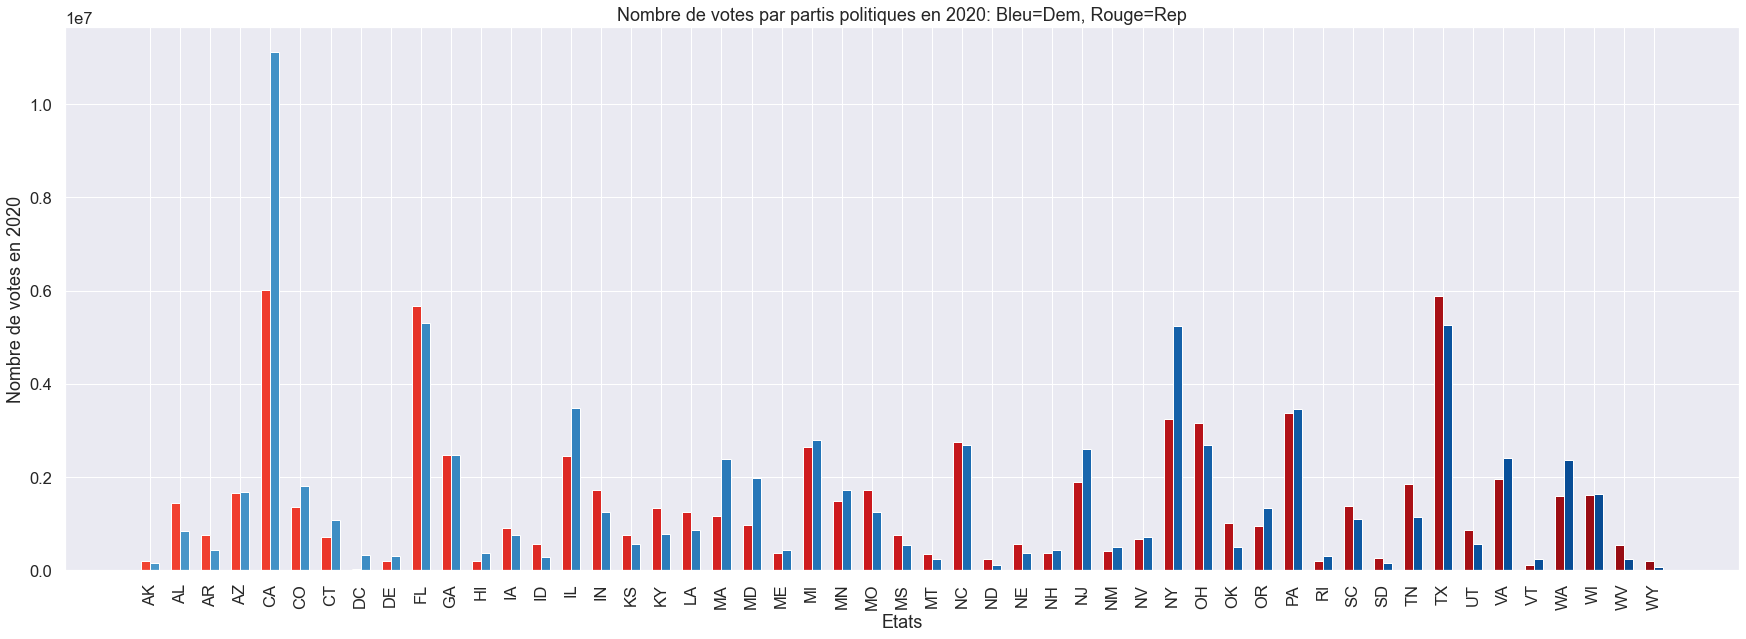

In [11]:
data_by_state_bar('votes_gop', 'votes_dem')

## 1.3 Import latitude et longitude pour visualisation

In [12]:
# Import data localisation: fips, long, lat
data_loc = pd.read_csv('us_county_latlng.csv')

# Classement par fips croissant puis visualisation des premières lignes de data_loc:
data_loc.sort_values(by=['fips_code']).head()

fips_code     name        lng        lat
2527       1001  Autauga -86.642900  32.535142
145        1003  Baldwin -87.722745  30.727825
2528       1005  Barbour -85.391068  31.870090
2058       1007     Bibb -87.126814  32.998376
3052       1009   Blount -86.567006  33.980871

In [13]:
# Il y a plus de fips code que dans les data des élections
data_loc.drop(columns=['name'], inplace=True)

# On renomme la colonne des fips avant de merger: création de data_geo: data+long+lat
data_loc = data_loc.rename(columns={'fips_code':'county_fips'} )
data_geo = pd.merge(data, data_loc, how="left", on=["county_fips"])
data_geo.head()

state_code state_name  county_fips     county_name  votes_gop  votes_dem  \
0         AL    Alabama         1001  Autauga County      19838       7503   
1         AL    Alabama         1003  Baldwin County      83544      24578   
2         AL    Alabama         1005  Barbour County       5622       4816   
3         AL    Alabama         1007     Bibb County       7525       1986   
4         AL    Alabama         1009   Blount County      24711       2640   

   total_votes   per_gop   per_dem  target        lng        lat  
0        27770  0.714368  0.270184       1 -86.642900  32.535142  
1       109679  0.761714  0.224090       1 -87.722745  30.727825  
2        10518  0.534512  0.457882       1 -85.391068  31.870090  
3         9595  0.784263  0.206983       1 -87.126814  32.998376  
4        27588  0.895716  0.095694       1 -86.567006  33.980871

Text(0.5, 1.0, 'Elections de 2020: pourcentage de votes républicains')

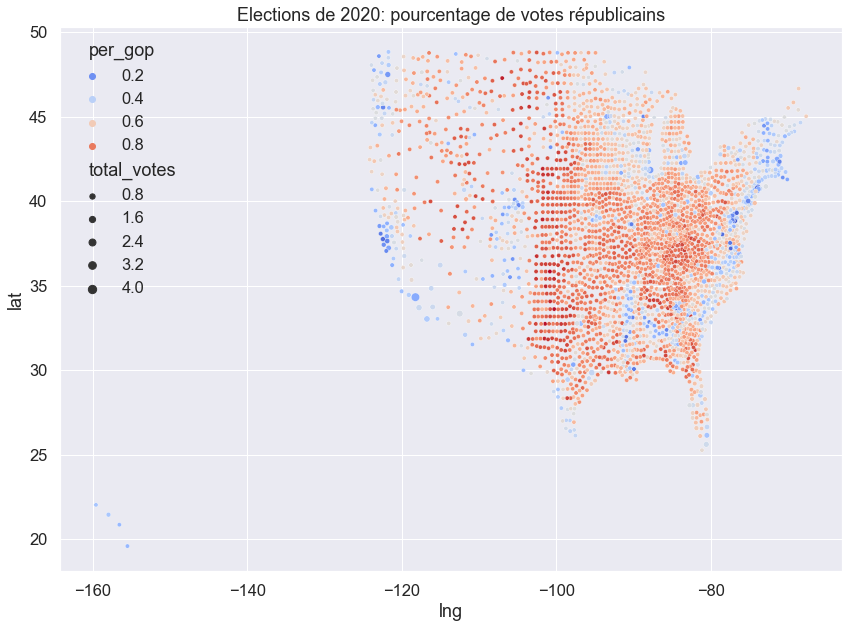

In [14]:
# Scatter plot des votes dem en utilisant la longitute et la latitude
plt.figure(figsize = (14,10))
sns.scatterplot(data = data_geo, x = "lng", y = "lat", hue = "per_gop", palette = "coolwarm", size='total_votes')
plt.title("Elections de 2020: pourcentage de votes républicains")

## 1.4 Import Education: analyse des variables influentes

In [15]:
education = pd.read_excel('Education.xls', skiprows = 4)
education.head()

FIPS Code State       Area name  2003 Rural-urban Continuum Code  \
0          0    US   United States                              NaN   
1       1000    AL         Alabama                              NaN   
2       1001    AL  Autauga County                              2.0   
3       1003    AL  Baldwin County                              4.0   
4       1005    AL  Barbour County                              6.0   

   2003 Urban Influence Code  2013 Rural-urban Continuum Code  \
0                        NaN                              NaN   
1                        NaN                              NaN   
2                        2.0                              2.0   
3                        5.0                              3.0   
4                        6.0                              6.0   

   2013 Urban Influence Code  Less than a high school diploma, 1970  \
0                        NaN                             52373312.0   
1                        NaN                              1062306.0   
2                        2.0                                 6611.0   
3                        2.0                                18726.0   
4                        6.0                                 8120.0   

   High school diploma only, 1970  Some college (1-3 years), 1970  \
0                      34158051.0                      11650730.0   
1                        468269.0                        136287.0   
2                          3757.0                           933.0   
3                          8426.0                          2334.0   
4                          2242.0                           581.0   

   Four years of college or higher, 1970  \
0                             11717266.0   
1                               141936.0   
2                                  767.0   
3                                 2038.0   
4                                  861.0   

   Percent of adults with less than a high school diploma, 1970  \
0                                               47.7              
1                                               58.7              
2                                               54.8              
3                                               59.4              
4                                               68.8              

   Percent of adults with a high school diploma only, 1970  \
0                                               31.1         
1                                               25.9         
2                                               31.1         
3                                               26.7         
4                                               19.0         

   Percent of adults completing some college (1-3 years), 1970  \
0                                               10.6             
1                                                7.5             
2                                                7.7             
3                                                7.4             
4                                                4.9             

   Percent of adults completing four years of college or higher, 1970  \
0                                               10.7                    
1                                                7.8                    
2                                                6.4                    
3                                                6.5                    
4                                                7.3                    

   Less than a high school diploma, 1980  High school diploma only, 1980  \
0                             44535197.0                      45947035.0   
1                               964840.0                        704207.0   
2                                 7074.0                          6145.0   
3                                18125.0                         15380.0   
4                                 7759.0                          3671.0   

   Some c

In [23]:
education.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3283 entries, 0 to 3282
Data columns (total 47 columns):
 #   Column                                                                    Non-Null Count  Dtype  
---  ------                                                                    --------------  -----  
 0   FIPS Code                                                                 3283 non-null   int64  
 1   State                                                                     3283 non-null   object 
 2   Area name                                                                 3283 non-null   object 
 3   2003 Rural-urban Continuum Code                                           3221 non-null   float64
 4   2003 Urban Influence Code                                                 3221 non-null   float64
 5   2013 Rural-urban Continuum Code                                           3221 non-null   float64
 6   2013 Urban Influence Code                                       

In [16]:
# Suppression de colonnes inutiles

education.drop(columns=['Area name', '2003 Rural-urban Continuum Code',
                       '2003 Urban Influence Code','2013 Rural-urban Continuum Code' ,
                       '2013 Urban Influence Code'], inplace=True)


# On renomme les colonnes des pourcentages en fonction des diplômes depuis 1990
list_niveau= ['Percent of adults with less than a high school diploma, ',
             'Percent of adults with a high school diploma only, ',
              "Percent of adults completing some college or associate's degree, ",
             "Percent of adults with a bachelor's degree or higher, "]
short_niveau=["pc_no_diploma", "pc_high_school", "pc_degree", "pc_high_degree"]


list_year = ['1990', '2000', '2015-19']
short_year = ['90', '00', '15-19']

def rename_education(old_name, new_name):

    for i,x in enumerate(list_year) :
        abrev = short_year[i]
        old = old_name+x
        new = new_name+'_'+abrev
        education.rename(columns={old: new}, inplace=True)
        
for i,x in enumerate(list_niveau):
    old_name=x
    new_name=short_niveau[i]
    rename_education(old_name, new_name)

In [17]:
# Réduction du nombre de variables
col_educ= education.columns.tolist()
col_sel=['FIPS Code','pc_no_diploma_90', 'pc_high_school_90','pc_degree_90','pc_high_degree_90',
'pc_no_diploma_00','pc_high_school_00','pc_degree_00','pc_high_degree_00',  'pc_no_diploma_15-19',
'pc_high_school_15-19', 'pc_degree_15-19','pc_high_degree_15-19']  

# Création d'un dataframe education_short après sélection des colonnes de col_sel
education_short=education[col_sel]
education_short.head()

FIPS Code  pc_no_diploma_90  pc_high_school_90  pc_degree_90  \
0          0              24.8               30.0          24.9   
1       1000              33.1               29.4          21.7   
2       1001              30.0               32.0          23.5   
3       1003              26.8               31.8          24.6   
4       1005              44.4               27.1          16.7   

   pc_high_degree_90  pc_no_diploma_00  pc_high_school_00  pc_degree_00  \
0               20.3              19.6               28.6          27.4   
1               15.7              24.7               30.4          25.9   
2               14.5              21.3               33.8          26.9   
3               16.8              18.0               29.6          29.3   
4               11.8              35.3               32.4          21.3   

   pc_high_degree_00  pc_no_diploma_15-19  pc_high_school_15-19  \
0               24.4            11.998918             26.956844   
1               19.0            13.819302             30.800268   
2               18.0            11.483395             33.588459   
3               23.1             9.193843             27.659616   
4               10.9            26.786907             35.604542   

   pc_degree_15-19  pc_high_degree_15-19  
0        28.898697             32.145542  
1        29.912098             25.468332  
2        28.356571             26.571573  
3        31.284081             31.862459  
4        26.029837             11.578713

In [40]:
#print(f"education comporte {education.shape[0]} lignes et  {education.shape[1]} colonnes.")

In [18]:
# Fusion data et population: il faut d'abord renommer la colonne fips de population
education_short.rename(columns={'FIPS Code':'county_fips'}, inplace=True)
# Merge des 2 dataframe: on ne conserve que les codes fips présents dans data
data_educ = pd.merge(data_geo, education_short, how="left", on=["county_fips"])

C:\Users\sylvi\AppData\Local\Temp\ipykernel_9812\2665277104.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [26]:
#print(f"data_educ comporte {data_educ.shape[0]} lignes et  {data_educ.shape[1]} colonnes.")

In [27]:
#data_educ.head()

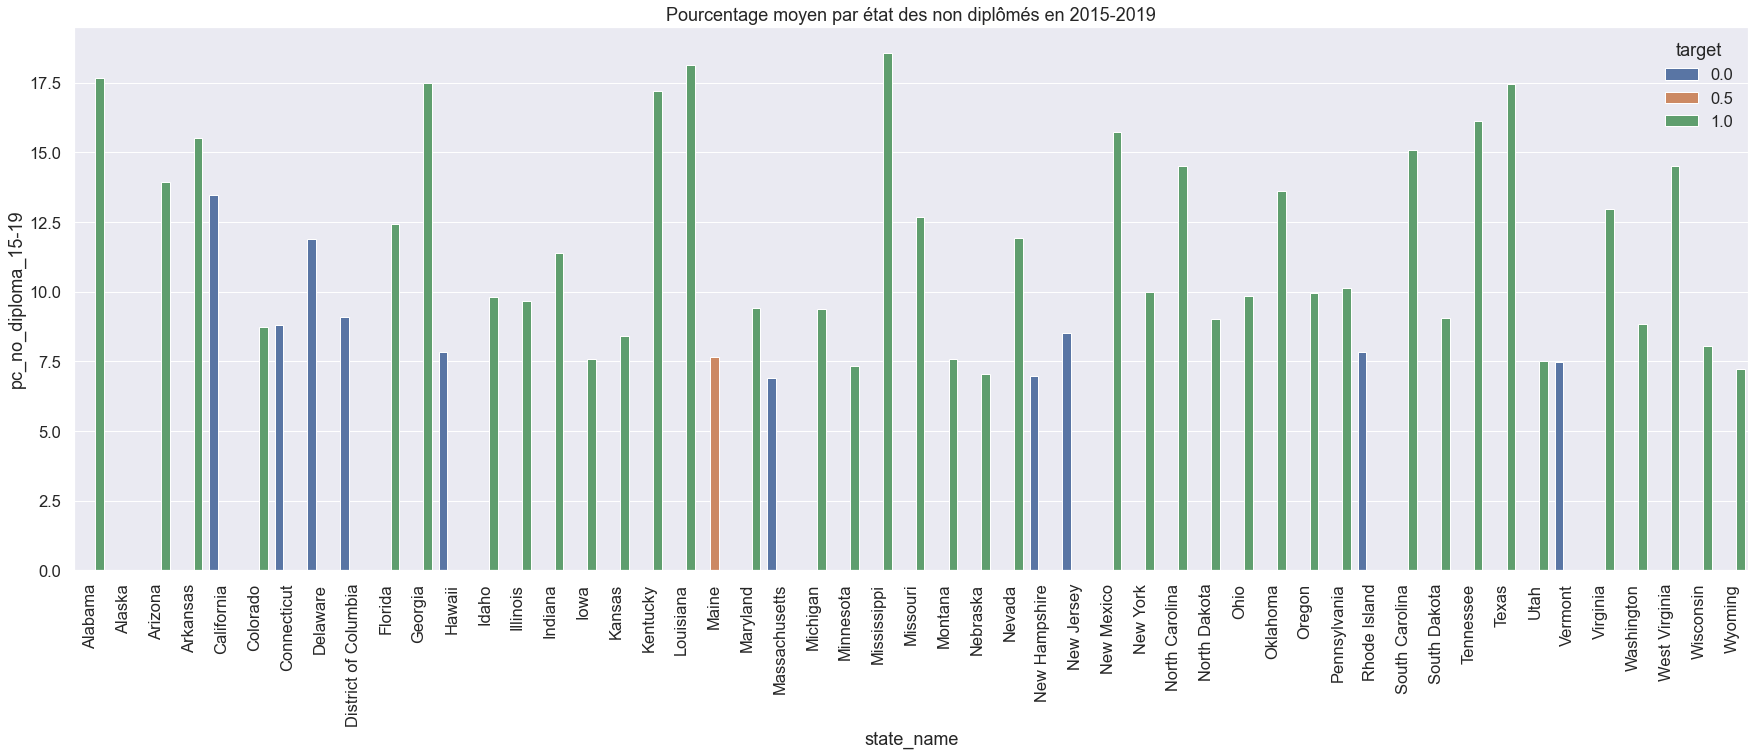

In [19]:
# Création d'un dataframe avec données groupées par état
data_educ_state = data_educ.groupby(by=['state_name']).median()
data_educ_state.head()

# Fonction graphique barplot
def data_educ_bar():
    x = np.arange(51)
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(30,10))
    w = 0.3
    i = 0

    plt.title('Pourcentage moyen par état des non diplômés en 2015-2019' )
    plt.xticks(x + w /2, data_educ_state.index, rotation='90')
    ax.set_xlabel('Etat')
    ax.set_ylabel('Pourcentage moyen par état des non diplômés en 2015-2019')
    
    sns.barplot( x=data_educ_state.index, y='pc_no_diploma_15-19', hue='target', data=data_educ_state)

# Affichage
sns.set(font_scale=1.5)
data_educ_bar()

<AxesSubplot:xlabel='target', ylabel='pc_high_degree_15-19'>

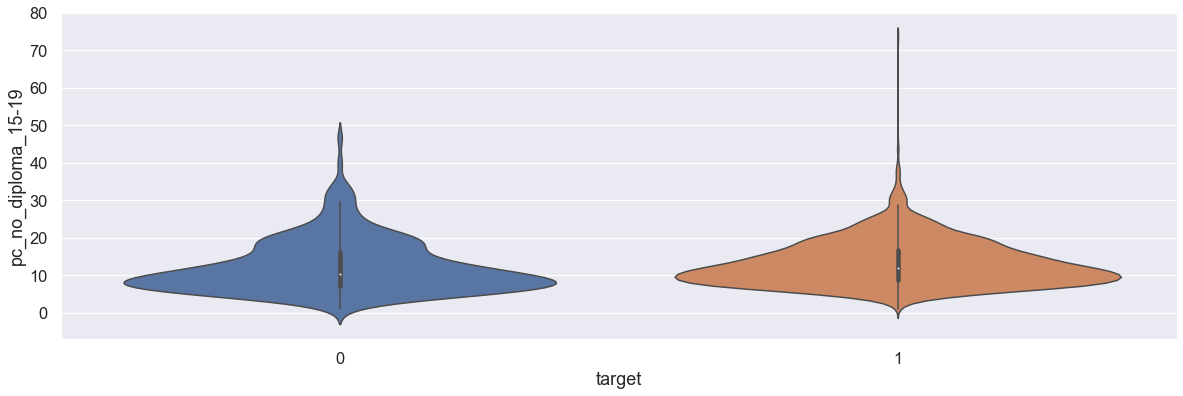

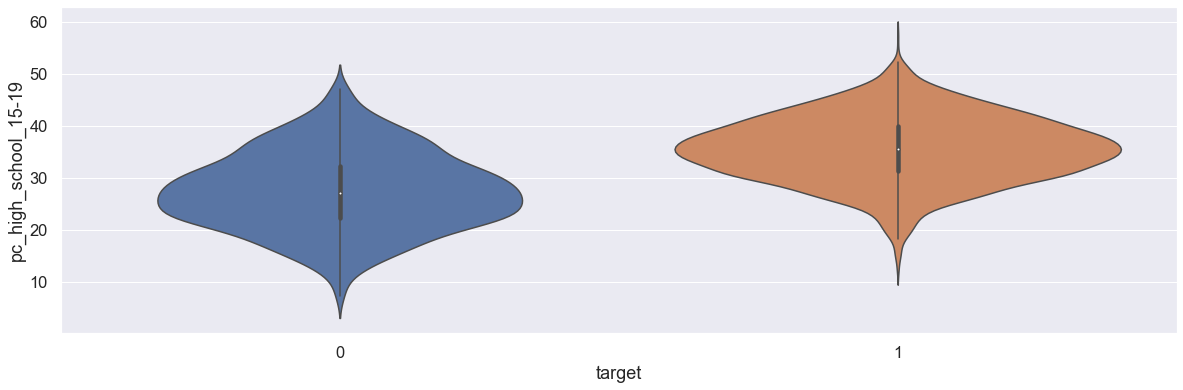

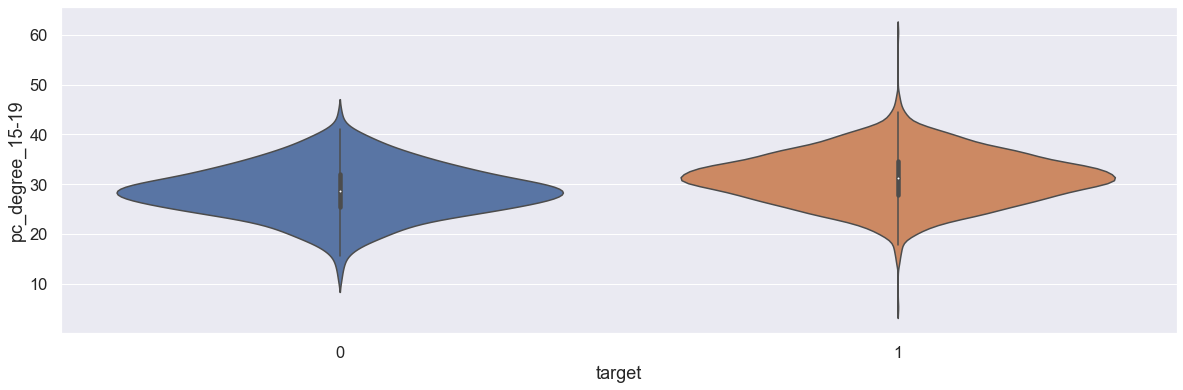

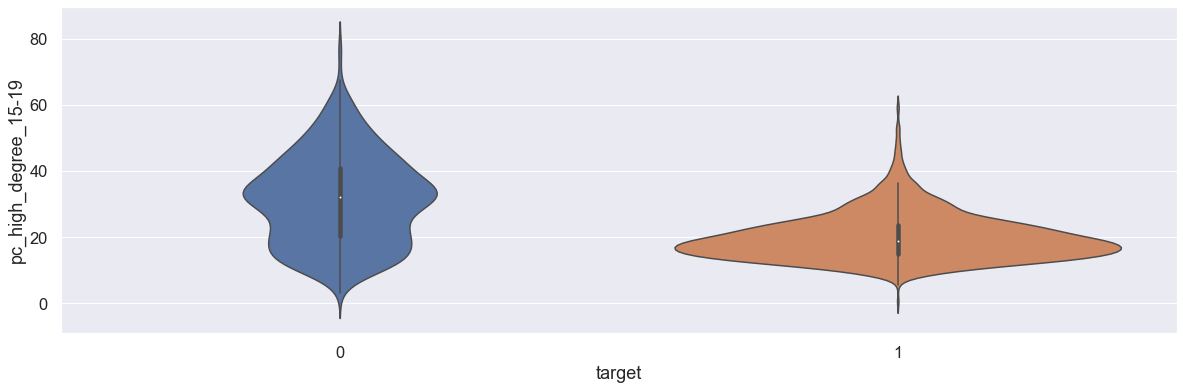

In [20]:
# Analyse graphique de l'influence du niveau scolaire sur le vote
fig, ax = plt.subplots(figsize=(20,6))
sns.violinplot(x='target', y='pc_no_diploma_15-19', data=data_educ, ax=ax)
fig, ax = plt.subplots(figsize=(20,6))
sns.violinplot(x='target', y='pc_high_school_15-19', data=data_educ, ax=ax)
fig, ax = plt.subplots(figsize=(20,6))
sns.violinplot(x='target', y='pc_degree_15-19', data=data_educ, ax=ax)
fig, ax = plt.subplots(figsize=(20,6))
sns.violinplot(x='target', y='pc_high_degree_15-19', data=data_educ, ax=ax)

Text(0.5, 1.0, 'Elections 2020: pourcentage de votes républicains')

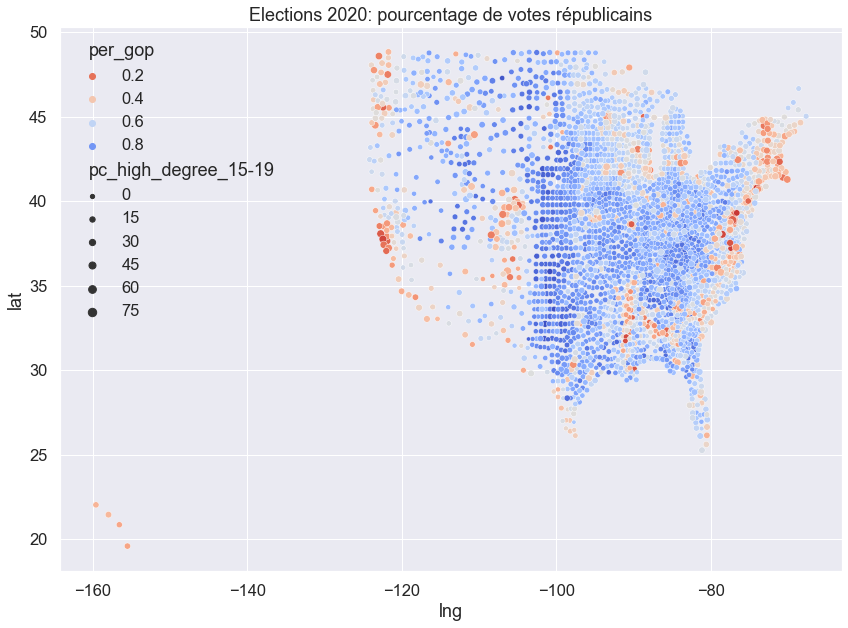

In [21]:
# Affichage des résultats sur la carte des US
plt.figure(figsize = (14,10))
sns.scatterplot(data = data_educ, x = "lng", y = "lat", 
                hue = "per_gop", palette = "coolwarm_r", size='pc_high_degree_15-19')
plt.title("Elections 2020: pourcentage de votes républicains")


In [155]:
#data_educ.drop(columns=['county_fips','votes_gop','votes_dem']).corr()['target']

## 1.5 Import poverty: analyse des variables influentes

In [33]:
#os.listdir()

In [22]:
poverty = pd.read_excel('PovertyEstimates.xls', skiprows = 4)
poverty.head()

FIPStxt Stabr       Area_name  Rural-urban_Continuum_Code_2003  \
0        0    US   United States                              NaN   
1     1000    AL         Alabama                              NaN   
2     1001    AL  Autauga County                              2.0   
3     1003    AL  Baldwin County                              4.0   
4     1005    AL  Barbour County                              6.0   

   Urban_Influence_Code_2003  Rural-urban_Continuum_Code_2013  \
0                        NaN                              NaN   
1                        NaN                              NaN   
2                        2.0                              2.0   
3                        5.0                              3.0   
4                        6.0                              6.0   

   Urban_Influence_Code_2013  POVALL_2019  CI90LBALL_2019  CI90UBALL_2019  \
0                        NaN     39490096        39248096        39732096   
1                        NaN       747478          730491          764465   
2                        2.0         6723            5517            7929   
3                        2.0        22360           18541           26179   
4                        6.0         5909            4787            7031   

   PCTPOVALL_2019  CI90LBALLP_2019  CI90UBALLP_2019  POV017_2019  \
0            12.3             12.2             12.4     12000470   
1            15.6             15.2             16.0       233890   
2            12.1              9.9             14.3         2040   
3            10.1              8.4             11.8         6323   
4            27.1             22.0             32.2         2050   

   CI90LB017_2019  CI90UB017_2019  PCTPOV017_2019  CI90LB017P_2019  \
0        11865995        12134945            16.8             16.6   
1          225712          242068            21.9             21.1   
2            1472            2608            15.9             11.5   
3            4521            8125            13.5              9.6   
4            1560            2540            41.0             31.2   

   CI90UB017P_2019  POV517_2019  CI90LB517_2019  CI90UB517_2019  \
0             17.0      8258906         8160650         8357162   
1             22.7       161670          154564          168776   
2             20.3         1376             902            1850   
3             17.4         4641            3295            5987   
4             50.8         1468            1114            1822   

   PCTPOV517_2019  CI90LB517P_2019  CI90UB517P_2019  MEDHHINC_2019  \
0            15.8             15.6             16.0          65712   
1            20.7             19.8             21.6          51771   
2            14.4              9.4             19.4          58233   
3            13.3              9.4             17.2          59871   
4            39.5             30.0             49.0          35972   

   CI90LBINC_2019  CI90UBINC_2019  POV04_2019  CI90LB04_2019  CI90UB04_2019  \
0           65594           65830   3457689.0      3405854.0      3509524.0   
1           51179           52363     69236.0        65296.0        73176.0   
2           52517           63949         NaN            NaN            NaN   
3           54593           65149         NaN            NaN            NaN   
4           31822           40122         NaN            NaN            NaN   

   PCTPOV04_2019  CI90LB04P_2019  CI90UB04P_2019  
0           18.2            17.9            18.5  
1           24.2            22.8            25.6  
2            NaN             NaN             NaN  
3            NaN             NaN             NaN  
4            NaN             NaN             NaN

In [23]:
# Suppression des variables inutiles
poverty.rename(columns={'FIPStxt':'county_fips'}, inplace=True)
poverty.drop(columns=['Rural-urban_Continuum_Code_2003','Urban_Influence_Code_2003',
                     'Rural-urban_Continuum_Code_2013','Urban_Influence_Code_2013',
                     'Stabr','Area_name'], inplace=True)

# Sélection des données les plus récentes
poverty_short=poverty[['county_fips','PCTPOVALL_2019','PCTPOV017_2019', 'PCTPOV517_2019']]

# Création du dataframe mis à jour
data_educ_pov = pd.merge(data_educ, poverty_short, how="left", on=["county_fips"])
data_educ_pov.head()

state_code state_name  county_fips     county_name  votes_gop  votes_dem  \
0         AL    Alabama         1001  Autauga County      19838       7503   
1         AL    Alabama         1003  Baldwin County      83544      24578   
2         AL    Alabama         1005  Barbour County       5622       4816   
3         AL    Alabama         1007     Bibb County       7525       1986   
4         AL    Alabama         1009   Blount County      24711       2640   

   total_votes   per_gop   per_dem  target        lng        lat  \
0        27770  0.714368  0.270184       1 -86.642900  32.535142   
1       109679  0.761714  0.224090       1 -87.722745  30.727825   
2        10518  0.534512  0.457882       1 -85.391068  31.870090   
3         9595  0.784263  0.206983       1 -87.126814  32.998376   
4        27588  0.895716  0.095694       1 -86.567006  33.980871   

   pc_no_diploma_90  pc_high_school_90  pc_degree_90  pc_high_degree_90  \
0              30.0               32.0          23.5               14.5   
1              26.8               31.8          24.6               16.8   
2              44.4               27.1          16.7               11.8   
3              48.2               33.8          13.2                4.7   
4              39.5               34.7          18.8                7.0   

   pc_no_diploma_00  pc_high_school_00  pc_degree_00  pc_high_degree_00  \
0              21.3               33.8          26.9               18.0   
1              18.0               29.6          29.3               23.1   
2              35.3               32.4          21.3               10.9   
3              36.8               35.7          20.4                7.1   
4              29.6               36.0          24.8                9.6   

   pc_no_diploma_15-19  pc_high_school_15-19  pc_degree_15-19  \
0            11.483395             33.588459        28.356571   
1             9.193843             27.659616        31.284081   
2            26.786907             35.604542        26.029837   
3            20.942602             44.878773        23.800098   
4            19.509438             33.422131        33.975021   

   pc_high_degree_15-19  PCTPOVALL_2019  PCTPOV017_2019  PCTPOV517_2019  
0             26.571573            12.1            15.9            14.4  
1             31.862459            10.1            13.5            13.3  
2             11.578713            27.1            41.0            39.5  
3             10.378526            20.3            25.9            25.2  
4             13.093413            16.3            21.0            21.4

Text(0.5, 1.0, 'Influence de la pauvreté en 2019 sur le vote républicain')

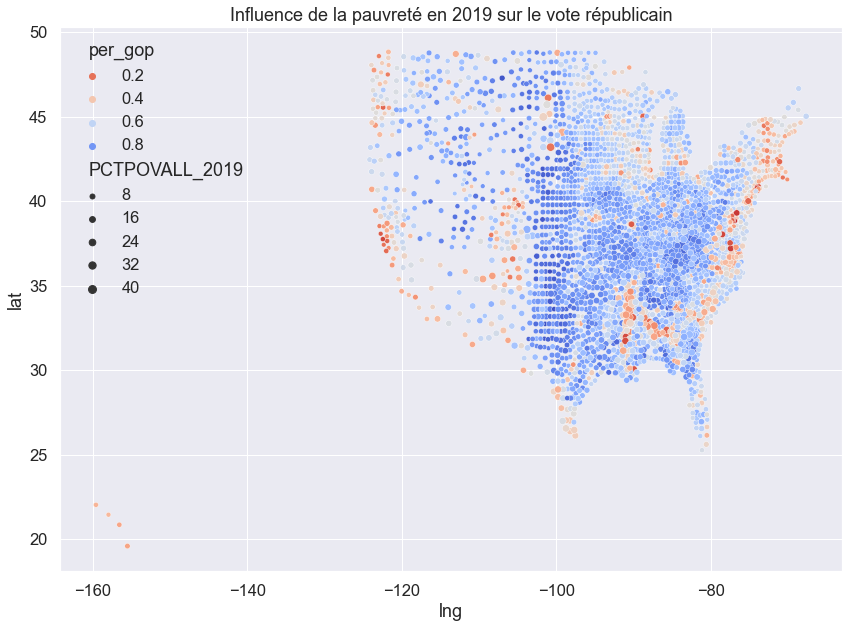

In [24]:
# Influence de la pauvreté en 2019 sur le vote républicain: visu carte US
plt.figure(figsize = (14,10))
sns.scatterplot(data = data_educ_pov, x = "lng", y = "lat", 
                hue = "per_gop", palette = "coolwarm_r", size='PCTPOVALL_2019')
plt.title("Influence de la pauvreté en 2019 sur le vote républicain")

<AxesSubplot:xlabel='target', ylabel='PCTPOV517_2019'>

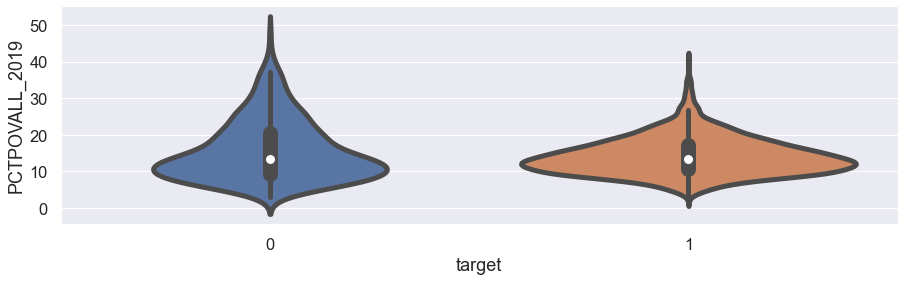

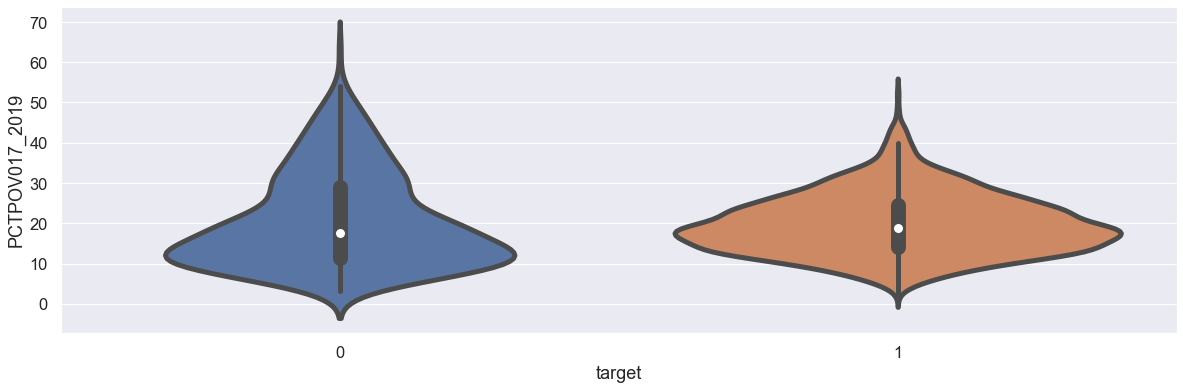

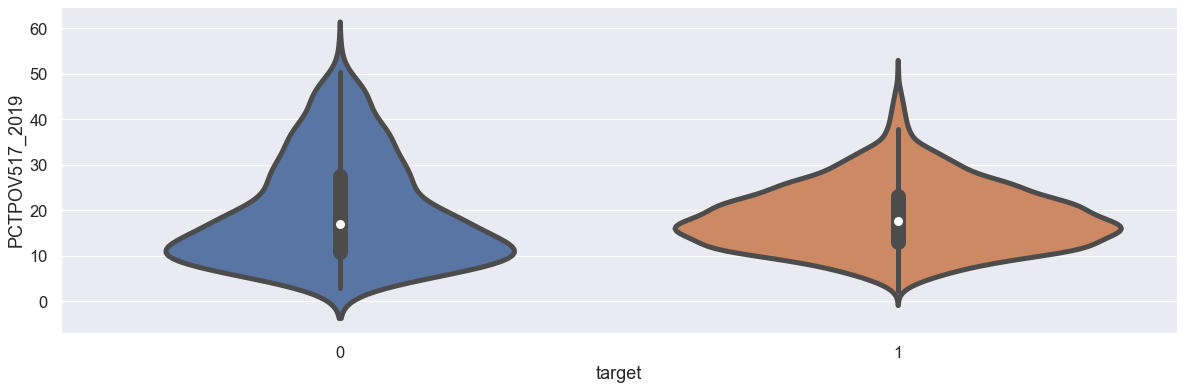

In [25]:
# Influence de la pauvreté en 2019 sur le type de vote
fig, ax = plt.subplots(figsize=(15,4))
sns.violinplot(x='target', y='PCTPOVALL_2019', inner='box', linewidth=5, data=data_educ_pov, ax=ax)
fig, ax = plt.subplots(figsize=(20,6))
sns.violinplot(x='target', y='PCTPOV017_2019', linewidth=5, data=data_educ_pov, ax=ax)
fig, ax = plt.subplots(figsize=(20,6))
sns.violinplot(x='target', y='PCTPOV517_2019', linewidth=5, data=data_educ_pov, ax=ax)


## 1.6 Import population: merge avec data_educ_pov = data_complet

In [27]:
# Import données démographiques
population = pd.read_excel('PopulationEstimates.xls', skiprows = 2)
#population.columns

In [28]:
# Suppression colonnes inutiles
population.rename(columns={'FIPStxt':'county_fips'}, inplace=True)
population.drop(columns=['Area_Name', 'Rural-urban_Continuum Code_2003',
                         'Rural-urban_Continuum Code_2013', 'Urban_Influence_Code_2003',
                         'Urban_Influence_Code_2013', 'Economic_typology_2015',
                         'CENSUS_2010_POP', 'ESTIMATES_BASE_2010'], inplace=True)

population=population.iloc[1:]
list_pop = population.columns.to_list()
col_drop_pop = list_pop[1:103]

population.drop(columns=col_drop_pop, inplace=True)

# Création du dataframe final
data_complet = pd.merge(data_educ_pov, population, how="left", on=["county_fips"])

# Visualisation du dataframe final: data_complet
data_complet.head()

state_code state_name  county_fips     county_name  votes_gop  votes_dem  \
0         AL    Alabama         1001  Autauga County      19838       7503   
1         AL    Alabama         1003  Baldwin County      83544      24578   
2         AL    Alabama         1005  Barbour County       5622       4816   
3         AL    Alabama         1007     Bibb County       7525       1986   
4         AL    Alabama         1009   Blount County      24711       2640   

   total_votes   per_gop   per_dem  target        lng        lat  \
0        27770  0.714368  0.270184       1 -86.642900  32.535142   
1       109679  0.761714  0.224090       1 -87.722745  30.727825   
2        10518  0.534512  0.457882       1 -85.391068  31.870090   
3         9595  0.784263  0.206983       1 -87.126814  32.998376   
4        27588  0.895716  0.095694       1 -86.567006  33.980871   

   pc_no_diploma_90  pc_high_school_90  pc_degree_90  pc_high_degree_90  \
0              30.0               32.0          23.5               14.5   
1              26.8               31.8          24.6               16.8   
2              44.4               27.1          16.7               11.8   
3              48.2               33.8          13.2                4.7   
4              39.5               34.7          18.8                7.0   

   pc_no_diploma_00  pc_high_school_00  pc_degree_00  pc_high_degree_00  \
0              21.3               33.8          26.9               18.0   
1              18.0               29.6          29.3               23.1   
2              35.3               32.4          21.3               10.9   
3              36.8               35.7          20.4                7.1   
4              29.6               36.0          24.8                9.6   

   pc_no_diploma_15-19  pc_high_school_15-19  pc_degree_15-19  \
0            11.483395             33.588459        28.356571   
1             9.193843             27.659616        31.284081   
2            26.786907             35.604542        26.029837   
3            20.942602             44.878773        23.800098   
4            19.509438             33.422131        33.975021   

   pc_high_degree_15-19  PCTPOVALL_2019  PCTPOV017_2019  PCTPOV517_2019  \
0             26.571573            12.1            15.9            14.4   
1             31.862459            10.1            13.5            13.3   
2             11.578713            27.1            41.0            39.5   
3             10.378526            20.3            25.9            25.2   
4             13.093413            16.3            21.0            21.4   

   R_birth_2011  R_birth_2012  R_birth_2013  R_birth_2014  R_birth_2015  \
0     11.600000     11.163449     10.412013     11.676701     11.862569   
1     11.842995     11.112202     11.219905     11.226489     11.225449   
2     12.109461     11.007155     10.423983      9.833867     10.219088   
3     11.575140     10.834141     11.418961     11.225984     11.126133   
4     12.946335     12.367553     11.232736     10.751661     12.446546   

   R_birth_2016  R_birth_2017  R_birth_2018  R_birth_2019  R_death_2011  \
0     12.097324     12.220585     11.377262     11.202671      9.345455   
1     11.204755     10.949200     10.734799     10.446871      9.895312   
2     10.597247     10.988364     10.513902     10.331329     11.816785   
3     12.225372     12.894364     10.330165     10.723621     12.101282   
4     12.171796     11.450282     11.751674     11.263268      9.901162   

   R_death_2012  R_death_2013  R_death_2014  R_death_2015  R_death_2016  \
0     10.165092     10.612595     10.454297     10.641690      9.935790   
1     10.007884      9.869361     10.084554     10.434644      9.850441   
2     10.493487     10.904521     11.472845     12.519326     10.750830   
3     10.393729     12.171373     10.959755     11.746714     10.675053   
4     10.196283     10.121616     10.195840     11.003720     11.302382   

   R_death_2017  R_death_20

In [29]:
# Nettoyage final
data_complet.drop(columns=['votes_gop', 'votes_dem','lng','lat'], inplace=True)

# Statistiques
data_complet.describe()

county_fips   total_votes      per_gop      per_dem       target  \
count   3152.000000  3.152000e+03  3152.000000  3152.000000  3152.000000   
mean   30299.778236  5.026445e+04     0.647805     0.333851     0.823287   
std    15209.461517  1.493792e+05     0.162014     0.159852     0.381486   
min     1001.000000  6.600000e+01     0.053973     0.030909     0.000000   
25%    18162.500000  5.414750e+03     0.554128     0.209978     1.000000   
50%    29166.000000  1.233550e+04     0.681720     0.300235     1.000000   
75%    45075.500000  3.330450e+04     0.773776     0.425830     1.000000   
max    56045.000000  4.263443e+06     0.961818     0.921497     1.000000   

       pc_no_diploma_90  pc_high_school_90  pc_degree_90  pc_high_degree_90  \
count       3111.000000        3111.000000   3111.000000        3111.000000   
mean          30.443748          34.293057     21.773192          13.489489   
std           10.340168           6.147550      5.900026           6.575543   
min            4.500000          13.500000      6.800000           3.700000   
25%           22.800000          30.300000     17.300000           9.200000   
50%           28.600000          33.800000     21.700000          11.800000   
75%           38.150000          38.500000     25.900000          15.600000   
max           68.400000          52.600000     43.300000          53.400000   

       pc_no_diploma_00  pc_high_school_00  pc_degree_00  pc_high_degree_00  \
count       3111.000000        3111.000000   3111.000000        3111.000000   
mean          22.653970          34.698329     26.129572          16.516651   
std            8.725873           6.559755      5.633778           7.800555   
min            3.000000          10.900000      9.900000           4.900000   
25%           16.100000          30.700000     22.100000          11.200000   
50%           20.800000          34.800000     26.200000          14.500000   
75%           28.800000          38.950000     30.100000          19.300000   
max           65.300000          53.200000     44.900000          63.700000   

       pc_no_diploma_15-19  pc_high_school_15-19  pc_degree_15-19  \
count          3112.000000           3112.000000      3112.000000   
mean             13.085088             34.147758        30.802965   
std               6.265950              7.226061         5.211923   
min               1.116910              7.265136         5.235602   
25%               8.479882             29.689806        27.290243   
50%              11.739182             34.538523        30.785382   
75%              16.708521             39.099957        34.214836   
max              73.560211             57.433674        60.563381   

       pc_high_degree_15-19  PCTPOVALL_2019  PCTPOV017_2019  PCTPOV517_2019  \
count           3112.000000     3112.000000     3112.000000     3112.000000   
mean              21.964189       14.470662       19.998008       18.760347   
std                9.582236        5.793896        8.493742        8.239852   
min                0.000000        2.700000        2.400000        2.200000   
25%               15.325250       10.400000       13.700000       12.600000   
50%               19.557242       13.400000       18.700000       17.500000   
75%               25.989834       17.500000       24.925000       23.500000   
max               77.557411       47.700000       63.400000       55.000000   

       R_birth_2011  R_birth_2012  R_birth_2013  R_birth_2014  R_birth_2015  \
count   3112.000000   3112.000000   3112.000000   3112.000000   3112.000000   
mean      11.707480     11.612219     11.618834     11.680572     11.729868   
std        2.655749      2.643972      2.630171      2.625713      2.604639   
min        2.574003      2.259887      1.445087      3.590664      3.646308   
25%       10.045831      9.949819      9.994716     10.085164     10.157151   
50%       11.515327     11.434897     11.459053     11.513618     11.522429   
75%       13

# 2. Premières modélisations avec 2 variables
#### Dans cette partie, on ne conserve que 2 variables afin de réaliser des graphes en 2D

## 2.1 Choix des variables

In [30]:
# Création de la matrice de corrélation pour pouvoir sélectionner les 2 variables les plus influentes
mat_cor=data_complet.corr()

In [31]:
mat_cor['per_gop'].sort_values(ascending=False)

per_gop                     1.000000
target                      0.781093
pc_high_school_00           0.497250
pc_high_school_15-19        0.488548
R_death_2012                0.394333
R_death_2013                0.384782
R_death_2014                0.383803
pc_high_school_90           0.378037
R_death_2015                0.377787
R_death_2011                0.377161
R_death_2017                0.366228
R_death_2016                0.360760
pc_no_diploma_90            0.271382
R_death_2018                0.253079
R_death_2019                0.226521
pc_no_diploma_00            0.194518
pc_degree_15-19             0.154604
pc_no_diploma_15-19         0.134040
county_fips                 0.076310
R_DOMESTIC_MIG_2019         0.062288
R_DOMESTIC_MIG_2015         0.049846
R_DOMESTIC_MIG_2018         0.049562
R_DOMESTIC_MIG_2013         0.047139
R_NET_MIG_2019              0.030047
R_DOMESTIC_MIG_2014         0.015267
R_DOMESTIC_MIG_2011         0.009212
R_NET_MIG_2018              0.008705
P

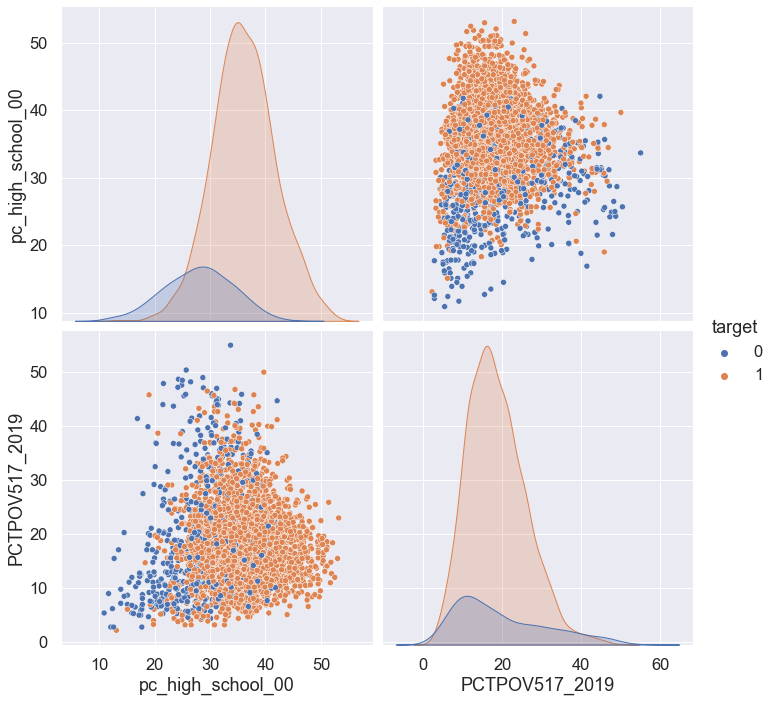

In [32]:
# Visualisation avec 2 variables
#data_visu=data_complet[['pc_high_degree_90','R_death_2012','target']]
data_visu=data_complet[['pc_high_school_00','PCTPOV517_2019','target']]
#data_visu=data_complet[['pc_no_diploma_00','R_death_2012','target']]

sns.pairplot(data_visu, hue="target", height=5)

In [106]:
#fig = px.scatter_3d(data_complet, x='pc_high_school_00', y='R_death_2012', z='PCTPOV517_2019',
#              color='target')
#fig.show()

## 2.2 Régression logistique à partir de 2 variables

https://medium.com/@cmukesh8688/sklearn-pipeline-gridsearchcv-54f5552bbf4e

In [161]:
#X=data_educ_pov[['pc_high_degree_15-19','PCTPOV517_2019']].values
#y=data_educ_pov[['target']].values.ravel()

In [34]:
X=data_complet[['pc_high_degree_15-19','PCTPOV517_2019']]
#X=data_complet[['pc_high_school_00','PCTPOV517_2019']]
y=data_complet['target']

In [35]:
# Séparation entre train et valid
X_train, X_valid, y_train, y_valid = train_test_split(X, y, train_size=0.8, random_state=42)

In [36]:
# pipeline complet
#preproc = make_pipeline(SimpleImputer(strategy="median"),StandardScaler())

log_reg = LogisticRegression()

preproc = Pipeline([
    ('imputer', SimpleImputer(strategy="median")), 
    ('scaler', StandardScaler())
    
])


pipe = Pipeline([
    ('imputer', SimpleImputer(strategy="median")), 
    ('scaler', StandardScaler()), 
    ('log_reg', log_reg)
])

pipe.fit(X_train,y_train)

Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                ('scaler', StandardScaler()),
                ('log_reg', LogisticRegression())])

In [37]:
y_pred = pipe.predict(X_valid)
print("Bilan de la régression logistique de base:")
print(f"- La matrice de confusion est: \n{confusion_matrix(y_valid, y_pred)} ")
print("")
print(f"- Le score f1 vaut: {f1_score(y_valid, y_pred):.2f}.")
print(f"- Le recall vaut: {recall_score(y_valid, y_pred):.2f}.")
print(f"- La précision vaut: {precision_score(y_valid, y_pred):.2f}.")

Bilan de la régression logistique de base:
- La matrice de confusion est: 
[[ 53  66]
 [ 21 491]] 

- Le score f1 vaut: 0.92.
- Le recall vaut: 0.96.
- La précision vaut: 0.88.


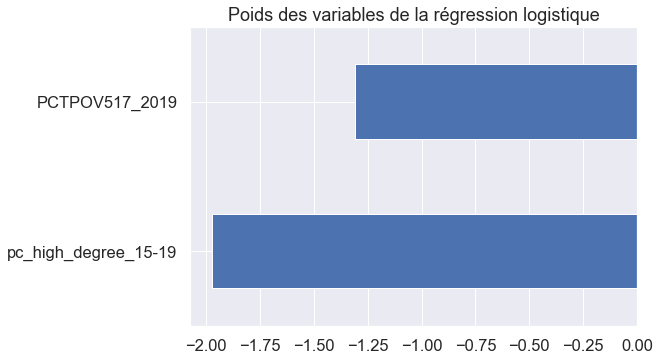

In [38]:
coefs = pipe[-1].coef_[0]  # coefficients = 2d array
weights = pd.Series(coefs, index=X.columns.to_list())
weights.plot.barh()
_ = plt.title("Poids des variables de la régression logistique")

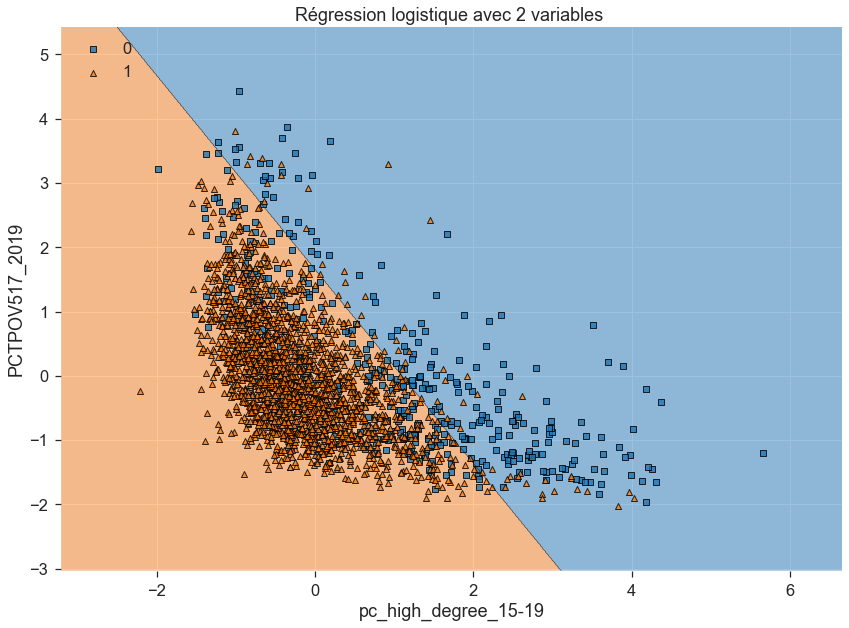

In [39]:
# pipeline sur le preprocessing pour X
# transformation y en vecteur
# pour affichage des frontières de décision


X_train_pr = preproc.fit_transform(X_train)


# Plotting decision regions
ax, fig = plt.subplots(figsize = (14,10))
plot_decision_regions(X_train_pr, y_train.values.ravel(), clf=log_reg, legend=2)

# Adding axes annotations

plt.xlabel('pc_high_degree_15-19')
plt.ylabel('PCTPOV517_2019')
plt.title('Régression logistique avec 2 variables ')
plt.show()

## 2.3 Régression logistique avec 2 variables: 
### Optimisation avec gridsearch

In [40]:
# Séparation entre train et valid
X_train, X_valid, y_train, y_valid = train_test_split(X, y, train_size=0.8, random_state=42)


# Utilisation de gridsearch CV avec une régression logistique


pipe = Pipeline([
    ('imputer', SimpleImputer(strategy="median")), 
    ('scaler', StandardScaler()), 
    ('logreg', log_reg)
])

# Create new parameter dictionary
grid_params = {
    # Key = step name from pipeline + __ + hyperparameter, value = tuple of possible values
    'logreg__solver' : ('saga', 'liblinear'),
    'logreg__penalty': ('l1', 'l2'),
    'logreg__C': (0.01, 0.1, 1, 10),
    'logreg__fit_intercept': (True, False)}



# Création de l'objet gridsearch object 
    
gs_reg = GridSearchCV(pipe, grid_params)

gs_reg.fit(X_train,y_train.values.ravel())

GridSearchCV(estimator=Pipeline(steps=[('imputer',
                                        SimpleImputer(strategy='median')),
                                       ('scaler', StandardScaler()),
                                       ('logreg', LogisticRegression())]),
             param_grid={'logreg__C': (0.01, 0.1, 1, 10),
                         'logreg__fit_intercept': (True, False),
                         'logreg__penalty': ('l1', 'l2'),
                         'logreg__solver': ('saga', 'liblinear')})

In [41]:
# Sélection du meilleur modèle
best_reg = gs_reg.best_estimator_

# Impact de l'optimisation sur le score
y_pred_best_reg = best_reg.predict(X_valid)
print('Bilan de la régression logistique optimisée:')
print(f"- La matrice de confusion est: \n{confusion_matrix(y_valid, y_pred_best_reg)} ")
print("")
print(f"- Le score f1 vaut: {f1_score(y_valid, y_pred_best_reg):.2f}.")
print(f"- Le recall vaut: {recall_score(y_valid, y_pred_best_reg):.2f}.")
print(f"- La précision vaut: {precision_score(y_valid, y_pred_best_reg):.2f}.")

Bilan de la régression logistique optimisée:
- La matrice de confusion est: 
[[ 53  66]
 [ 22 490]] 

- Le score f1 vaut: 0.92.
- Le recall vaut: 0.96.
- La précision vaut: 0.88.


In [42]:
# Affichage des meilleurs paramètres
print(f"Les meilleurs paramètres sont: {gs_reg.best_params_}.")

Les meilleurs paramètres sont: {'logreg__C': 1, 'logreg__fit_intercept': True, 'logreg__penalty': 'l1', 'logreg__solver': 'saga'}.


Aucun impact de l'optimisation. 

## 2.4 SVM non linéaire avec gridsearch

https://scikit-learn.org/stable/auto_examples/svm/plot_rbf_parameters.html

In [44]:
# Séparation entre train et valid
X_train, X_valid, y_train, y_valid = train_test_split(X, y, train_size=0.8, random_state=42)


# Utilisation de gridsearch CV avec une régression logistique


pipe = Pipeline([
    ('imputer', SimpleImputer(strategy="median")), 
    ('scaler', StandardScaler()), 
    ('svc', SVC())
])

In [45]:
 
# Paramètres pour gridsearch

grid_params_svc = {
    # Key = step name from pipeline + __ + hyperparameter, value = tuple of possible values
    'svc__C' : (0.1, 1, 10, 100, 1000),
    'svc__gamma': (1, 0.1, 0.01, 0.001),
    'svc__kernel': ['rbf','sigmoid']}


pipe_svc = Pipeline([
    ('imputer', SimpleImputer(strategy="median")), 
    ('scaler', StandardScaler()), 
    ('svc', SVC())
])


# Création de l'objet gridsearch object  et fit    
gs_svc = GridSearchCV(pipe_svc, grid_params_svc, cv=5, refit=True, verbose=2)

gs_svc.fit(X_train,y_train.values.ravel())

Fitting 5 folds for each of 40 candidates, totalling 200 fits
[CV] END ..........svc__C=0.1, svc__gamma=1, svc__kernel=rbf; total time=   0.0s
[CV] END ..........svc__C=0.1, svc__gamma=1, svc__kernel=rbf; total time=   0.0s
[CV] END ..........svc__C=0.1, svc__gamma=1, svc__kernel=rbf; total time=   0.0s
[CV] END ..........svc__C=0.1, svc__gamma=1, svc__kernel=rbf; total time=   0.0s
[CV] END ..........svc__C=0.1, svc__gamma=1, svc__kernel=rbf; total time=   0.0s
[CV] END ......svc__C=0.1, svc__gamma=1, svc__kernel=sigmoid; total time=   0.0s
[CV] END ......svc__C=0.1, svc__gamma=1, svc__kernel=sigmoid; total time=   0.0s
[CV] END ......svc__C=0.1, svc__gamma=1, svc__kernel=sigmoid; total time=   0.0s
[CV] END ......svc__C=0.1, svc__gamma=1, svc__kernel=sigmoid; total time=   0.0s
[CV] END ......svc__C=0.1, svc__gamma=1, svc__kernel=sigmoid; total time=   0.0s
[CV] END ........svc__C=0.1, svc__gamma=0.1, svc__kernel=rbf; total time=   0.0s
[CV] END ........svc__C=0.1, svc__gamma=0.1, sv

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('imputer',
                                        SimpleImputer(strategy='median')),
                                       ('scaler', StandardScaler()),
                                       ('svc', SVC())]),
             param_grid={'svc__C': (0.1, 1, 10, 100, 1000),
                         'svc__gamma': (1, 0.1, 0.01, 0.001),
                         'svc__kernel': ['rbf', 'sigmoid']},
             verbose=2)

In [46]:
# Choix du meilleur modèle
best_svm = gs_svc.best_estimator_

# Score de la svm optimisée
y_pred_best_svm = best_svm.predict(X_valid)
print('Bilan de la svm optimisée:')
print(f"- La matrice de confusion est: \n{confusion_matrix(y_valid, y_pred_best_svm)} ")
print("")
print(f"- Le score f1 vaut: {f1_score(y_valid, y_pred_best_svm):.2f}.")
print(f"- Le recall vaut: {recall_score(y_valid, y_pred_best_svm):.2f}.")
print(f"- La précision vaut: {precision_score(y_valid, y_pred_best_svm):.2f}.")

Bilan de la svm optimisée:
- La matrice de confusion est: 
[[ 48  71]
 [ 16 496]] 

- Le score f1 vaut: 0.92.
- Le recall vaut: 0.97.
- La précision vaut: 0.87.


Pas d'amélioration du score F1.

In [78]:
#scores = gs_svc.cv_results_['mean_test_score']
#scores.sort()
#scores

In [47]:
print('Voici les meilleurs paramètres pour la SVM:')
gs_svc.best_params_

Voici les meilleurs paramètres pour la SVM:


{'svc__C': 1000, 'svc__gamma': 0.1, 'svc__kernel': 'rbf'}

In [48]:
# Séparation entre train et valid
X_train, X_valid, y_train, y_valid = train_test_split(X, y, train_size=0.8, random_state=42)

pipe_svc_best = Pipeline([
    ('imputer', SimpleImputer(strategy="median")), 
    ('scaler', StandardScaler()), 
    ('svc', SVC(C=1000, gamma=0.1, kernel='rbf'))
])


preproc = Pipeline([
    ('imputer', SimpleImputer(strategy="median")), 
    ('scaler', StandardScaler())
    
])

svc = SVC(C=1000, gamma=0.1, kernel='rbf')


####################### 

X_train_pr = preproc.fit_transform(X_train)

svc.fit(X_train_pr,y_train.values.ravel())


#######################


#pipe_svc_best.fit(X_train,y_train.values.ravel())



SVC(C=1000, gamma=0.1)

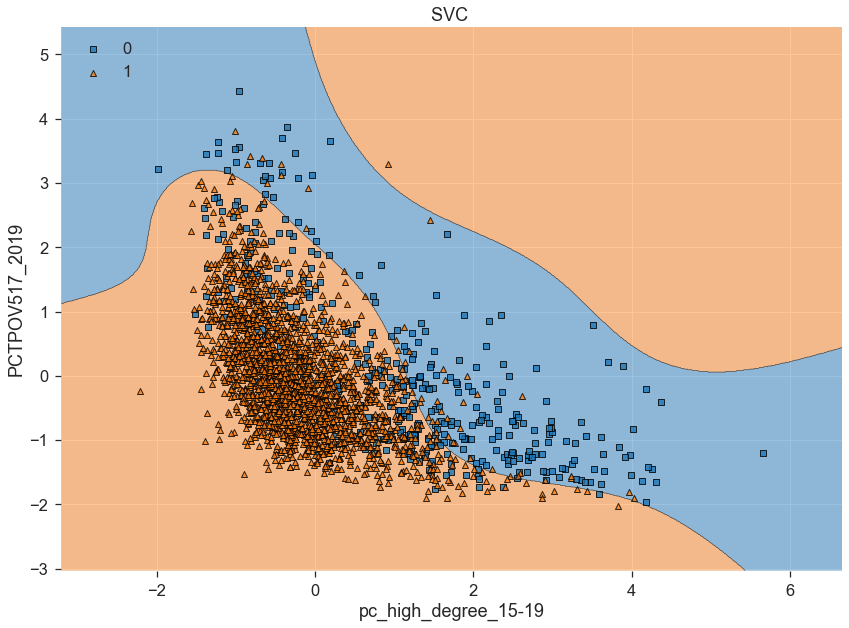

In [49]:
#######################

# Tracé des frontières de décision
ax, fig = plt.subplots(figsize = (14,10))
plot_decision_regions(X_train_pr, y_train.values.ravel(), clf=svc, legend=2)

# Titres

plt.xlabel('pc_high_degree_15-19')
plt.ylabel('PCTPOV517_2019')
plt.title('SVC ')
plt.show()

* https://zekehochberg.github.io/pipeline-and-gridsearch/
* https://medium.com/@cmukesh8688/sklearn-pipeline-gridsearchcv-54f5552bbf4e

# 3. Random forest: 
### Il s'agit de déterminer les variables les plus influentes pour effectuer une analyse plus poussée.

-https://www.kaggle.com/code/pepacz/randomforestclassifier-with-sklearn-pipeline

## 3.1. Choix des variables: préselection initiale

In [50]:
# Création X et y
X=data_complet.select_dtypes(exclude=['object'])
X.drop(columns=['county_fips','total_votes','per_gop','per_dem','target'], inplace=True)
y=data_complet['target']

In [51]:
list_col=X.columns.tolist()

In [52]:
X.shape

(3152, 69)

## 3.2. Modèle de base

In [69]:
# Séparation entre train et valid
X_train, X_valid, y_train, y_valid = train_test_split(X, y, train_size=0.8, random_state=42)


# Utilisation de gridsearch CV avec une random forest

# warm_start=True pour avoir accès à estimator_

rf_clf = RandomForestClassifier(n_estimators=200, n_jobs=10, 
                                random_state=42,
                                max_depth=5,
                               warm_start=True)

preproc = Pipeline([
    ('imputer', SimpleImputer(strategy="median")), 
    ('scaler', StandardScaler())
    
])

pipe_rf = Pipeline([
    ('preprocessor', preproc), 
    ('classifier', rf_clf)
])

pipe_rf.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                                 ('scaler', StandardScaler())])),
                ('classifier',
                 RandomForestClassifier(max_depth=5, n_estimators=200,
                                        n_jobs=10, random_state=42,
                                        warm_start=True))])

In [70]:
# Scores du modèle Random Forest de base
y_pred_rnd_for = pipe_rf.predict(X_valid)
print("Bilan d'une forêt aléatoire simple:")
print(f"- La matrice de confusion est: \n{confusion_matrix(y_valid, y_pred_rnd_for)} ")
print("")
print(f"- Le score f1 vaut: {f1_score(y_valid, y_pred_rnd_for):.2f}.")
print(f"- Le recall vaut: {recall_score(y_valid, y_pred_rnd_for):.2f}.")
print(f"- La précision vaut: {precision_score(y_valid, y_pred_rnd_for):.2f}.")

Bilan d'une forêt aléatoire simple:
- La matrice de confusion est: 
[[ 57  62]
 [ 13 499]] 

- Le score f1 vaut: 0.93.
- Le recall vaut: 0.97.
- La précision vaut: 0.89.


## 3.3. Optimisation du degré de randomization

In [65]:
# Séparation entre train et valid
X_train, X_valid, y_train, y_valid = train_test_split(X, y, train_size=0.8, random_state=42)
thresholds = np.linspace(0.01, 1, num=10)
scores = []

# Boucle sur thresholds avec sauvegarde des scores

for t in thresholds:
    rf_clf = RandomForestClassifier(n_estimators=200, 
                                    max_features=t,
                                    n_jobs=10, 
                                    random_state=42,
                                   warm_start=True)

    pipe_rf = Pipeline([
        ('preprocessor', preproc), 
        ('classifier', rf_clf)
    ])

    y_train_pred = cross_val_predict(pipe_rf, X_train, y_train, 
                                     cv=5, n_jobs=5)

    scores.append(f1_score(y_train, y_train_pred))

Valeur optimale de max_features : 0.56
Score F1 : 0.9372952737482453


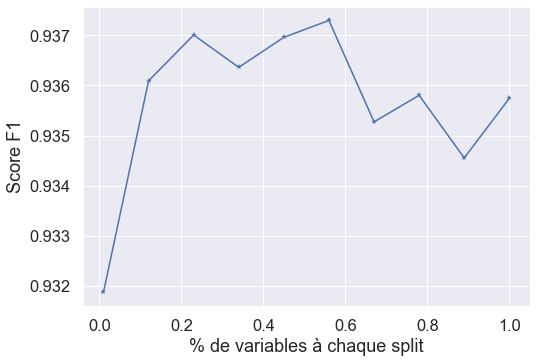

In [66]:
# Tracé des scores en fonctions du seuil
plt.plot(thresholds, scores, marker='*')
_=plt.xlabel("% de variables à chaque split")
_=plt.ylabel("Score F1")

print(f"Valeur optimale de max_features : {thresholds[np.argmax(scores)]}")
print(f"Score F1 : {np.max(scores)}")

## 3.4.Visualisation des arbres de la forêt aléatoire
+ https://towardsdatascience.com/how-to-visualize-a-decision-tree-from-a-random-forest-in-python-using-scikit-learn-38ad2d75f21c
+ https://mljar.com/blog/visualize-tree-from-random-forest/

In [71]:
# Enregistrement du classifieur de la pipeline pipe_rf sous model
model=pipe_rf.steps[1][1]
model

RandomForestClassifier(max_depth=5, n_estimators=200, n_jobs=10,
                       random_state=42, warm_start=True)

In [74]:
estimator = model.estimators_
print(f"Le nombre d'arbres de la forêt aléatoire est de {len(estimator)}.")

Le nombre d'arbres de la forêt aléatoire est de 200.


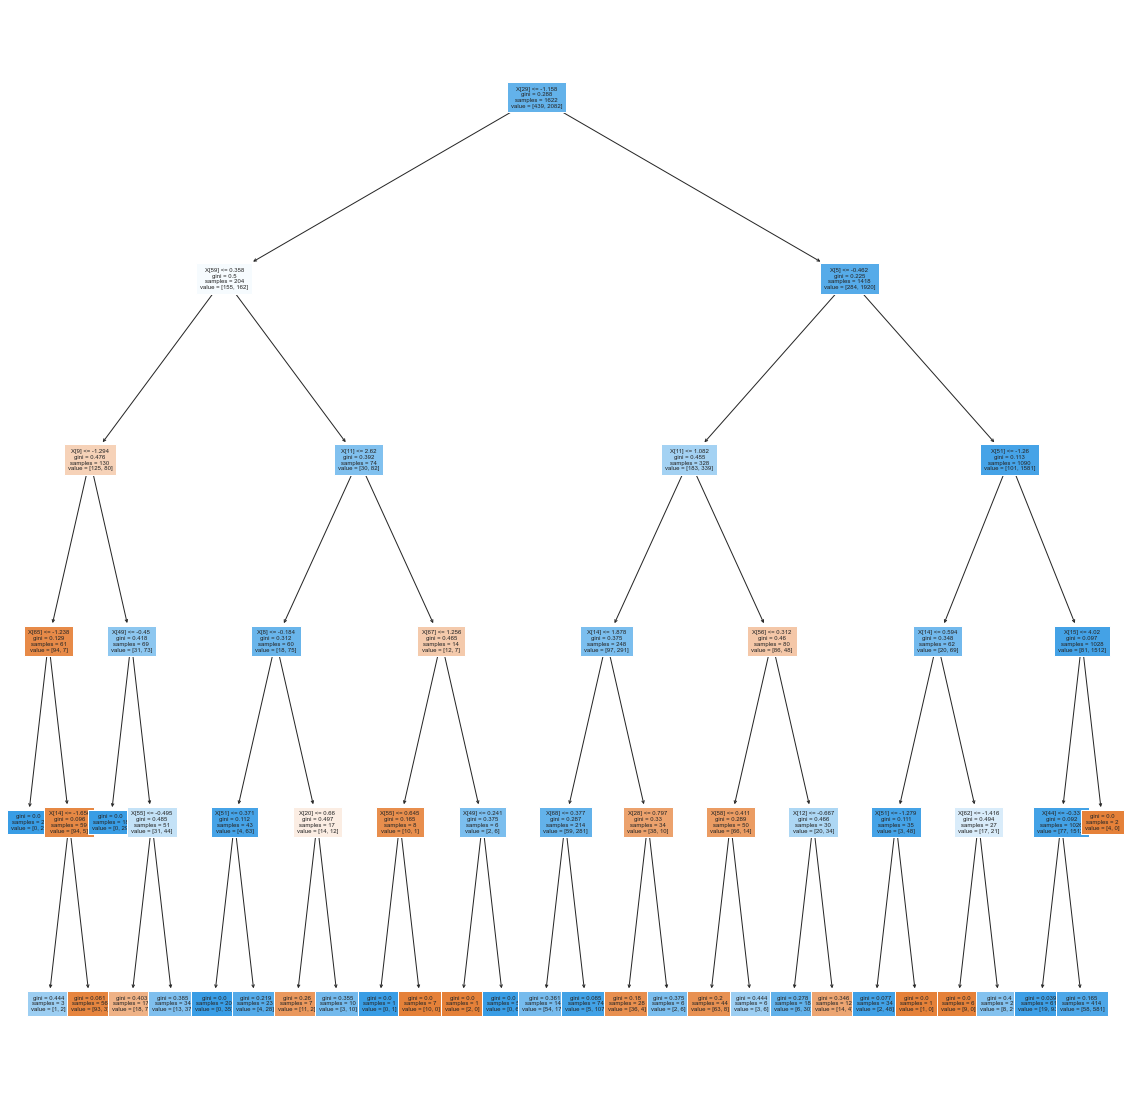

In [75]:
# Visualisation de l'arbre n
feature_names=list(X_train.columns)
n=0
plt.figure(figsize=(20,20))
_ = tree.plot_tree(model.estimators_[n], filled=True, fontsize=6)

# Sauvegarde avec une haute résolution
plt.savefig("decistion_tree.jpeg", dpi=200)

In [76]:
# Taille de l'arbre
model.estimators_[0].tree_.max_depth

5

## 3.5. Importance des variables

In [77]:
_ = pipe_rf.fit(X_train, y_train)

C:\Users\sylvi\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:429: UserWarning:

Warm-start fitting without increasing n_estimators does not fit new trees.



In [78]:
col_names = X_train.columns
features_importances = pipe_rf.named_steps["classifier"].feature_importances_
forest_importances = pd.Series(features_importances, index=col_names)

In [80]:
# Choix des 20 premières variables
forest_importances.sort_values(ascending=False, inplace=True)
forest_importances=forest_importances.iloc[:20]

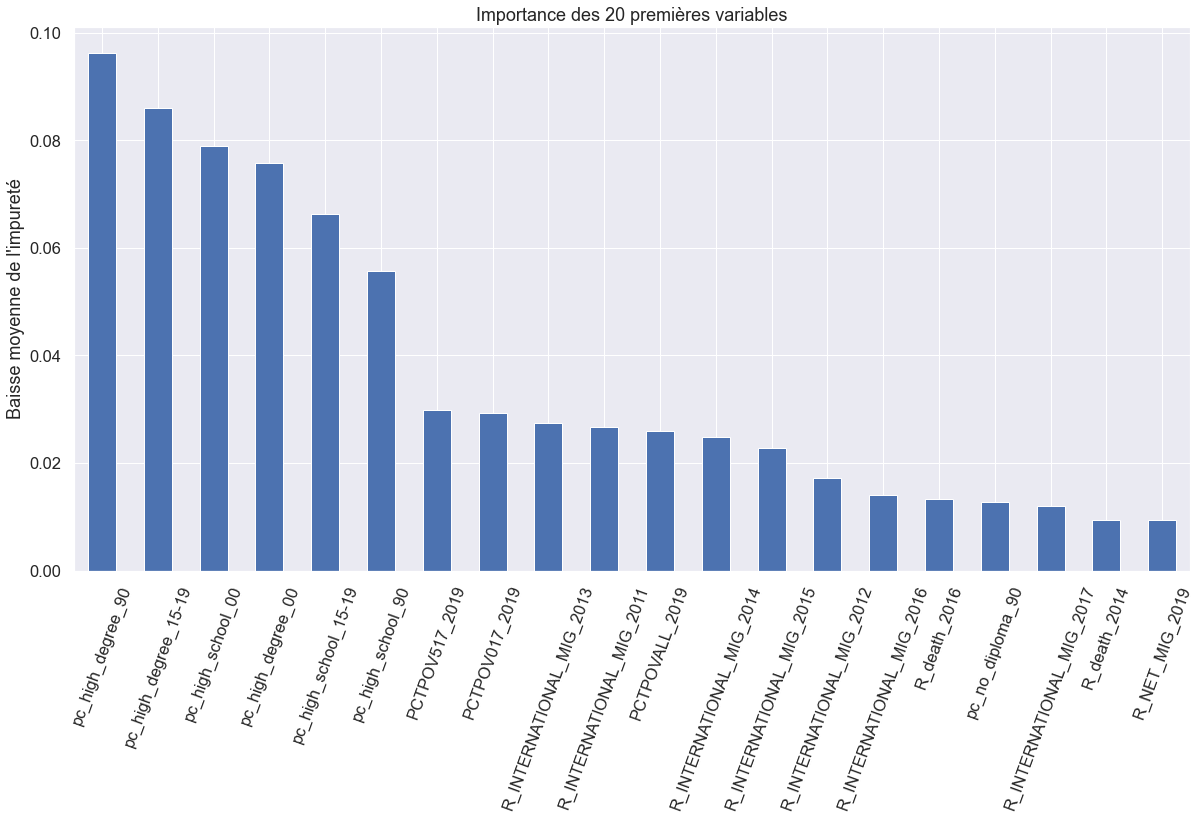

In [275]:
# Tracé de l'influence des variables
fig, ax = plt.subplots(figsize=(20,10))
forest_importances.plot.bar(ax=ax)
ax.set_title("Importance des 20 premières variables")
ax.set_ylabel("Baisse moyenne de l'impureté")
_=plt.xticks(rotation = 70)
#fig.tight_layout()

In [86]:
# Sélection fine des variables
fine_selection = forest_importances.index[0:10]

In [87]:
# Mise à jour de X à partir des résultats de random forest
# Création X et y
X=data_complet.select_dtypes(exclude=['object'])
X.drop(columns=['county_fips','total_votes','per_gop','per_dem','target'], inplace=True)
y=data_complet['target']
X=X[fine_selection]

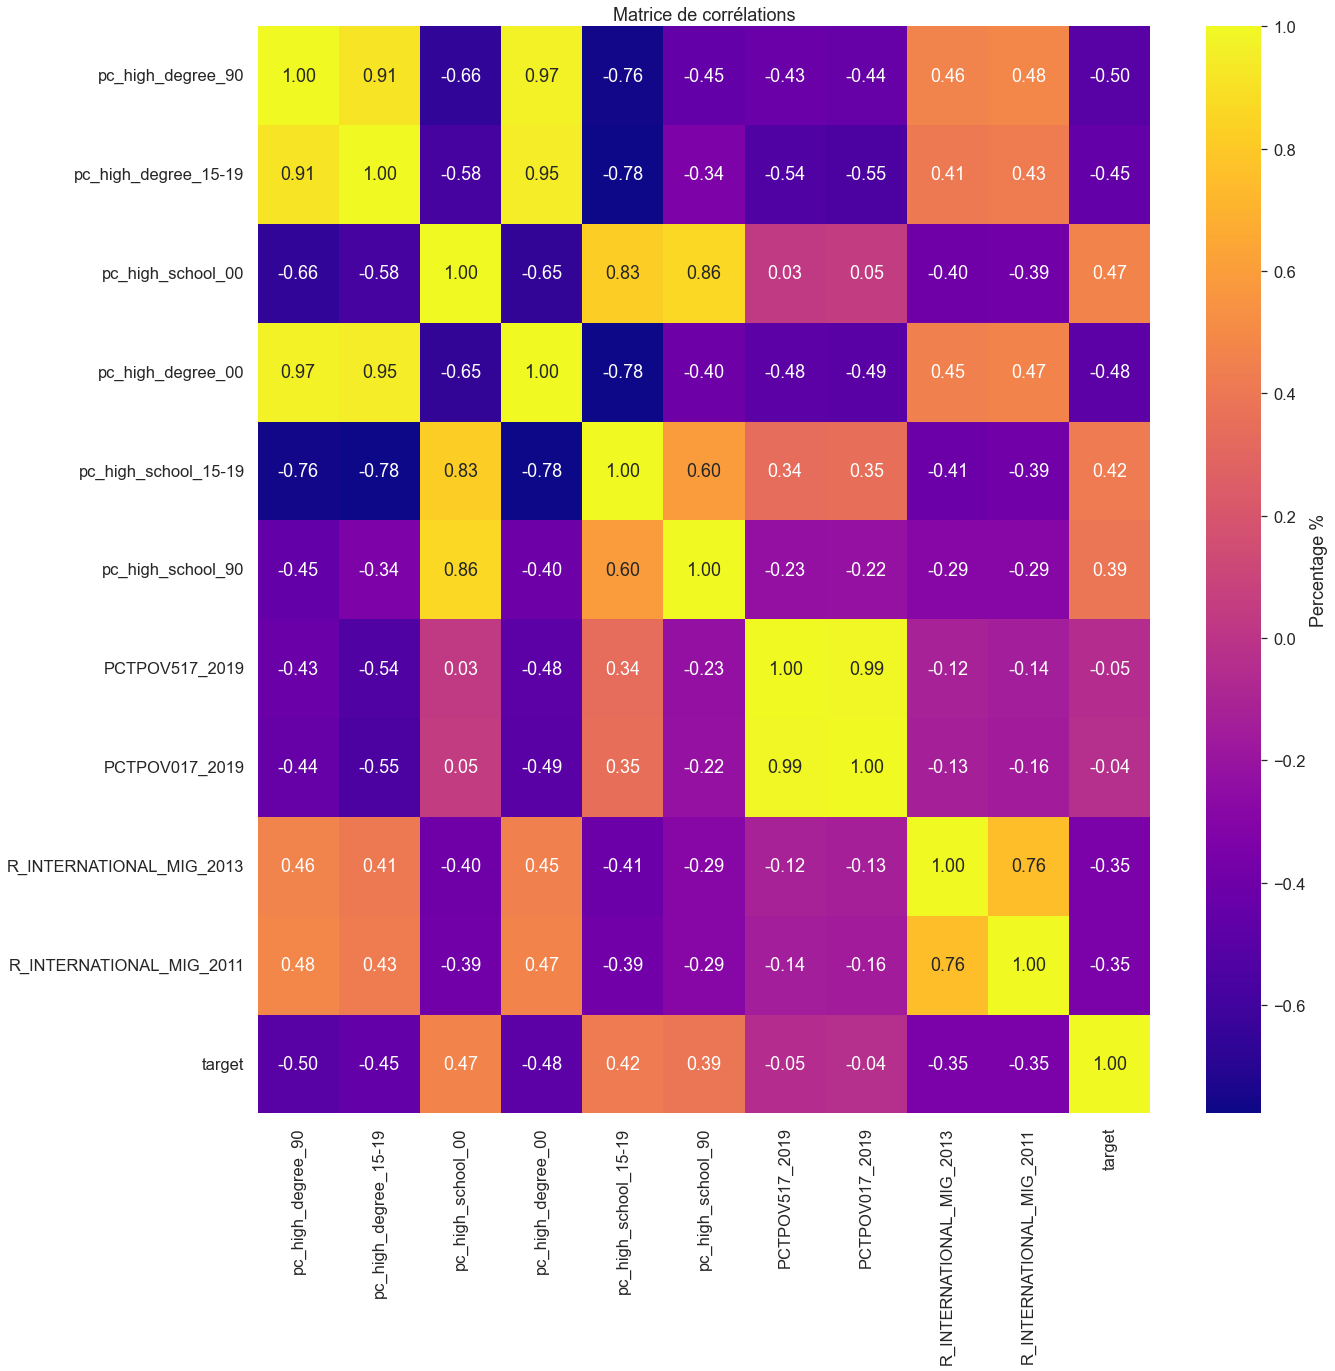

In [88]:
# Visualisation des corrélations
f, ax = plt.subplots(figsize=[20,20])
sns.heatmap(pd.concat([X, y], axis=1).corr(),
            annot=True, fmt=".2f",cbar_kws={'label': 'Percentage %'},cmap="plasma",ax=ax)
ax.set_title("Matrice de corrélations")
plt.show()

## 3.6.SVM après sélection des variables influentes

https://towardsdatascience.com/how-to-visualize-a-decision-tree-from-a-random-forest-in-python-using-scikit-learn-38ad2d75f21c

In [101]:
# Création X et y
X=data_complet.select_dtypes(exclude=['object'])
X.drop(columns=['county_fips','total_votes','per_gop','per_dem','target'], inplace=True)
y=data_complet['target']
X=X[fine_selection]

In [104]:
# Séparation entre train et valid
X_train, X_valid, y_train, y_valid = train_test_split(X, y, train_size=0.8, random_state=42)


In [105]:
 
# Paramètres pour gridsearch

grid_params_svc = {
    # Key = step name from pipeline + __ + hyperparameter, value = tuple of possible values
    'svc__C' : (0.1, 1, 10, 100, 1000),
    'svc__gamma': (1, 0.1, 0.01, 0.001),
    'svc__kernel': ['rbf','sigmoid']}


pipe_svc = Pipeline([
    ('imputer', SimpleImputer(strategy="median")), 
    ('scaler', StandardScaler()), 
    ('svc', SVC())
])


# Création de l'objet gridsearch object  et fit    
gs_svc = GridSearchCV(pipe_svc, grid_params_svc, cv=5, refit=True, verbose=2)

gs_svc.fit(X_train,y_train.values.ravel())

Fitting 5 folds for each of 40 candidates, totalling 200 fits
[CV] END ..........svc__C=0.1, svc__gamma=1, svc__kernel=rbf; total time=   0.1s
[CV] END ..........svc__C=0.1, svc__gamma=1, svc__kernel=rbf; total time=   0.1s
[CV] END ..........svc__C=0.1, svc__gamma=1, svc__kernel=rbf; total time=   0.1s
[CV] END ..........svc__C=0.1, svc__gamma=1, svc__kernel=rbf; total time=   0.1s
[CV] END ..........svc__C=0.1, svc__gamma=1, svc__kernel=rbf; total time=   0.1s
[CV] END ......svc__C=0.1, svc__gamma=1, svc__kernel=sigmoid; total time=   0.0s
[CV] END ......svc__C=0.1, svc__gamma=1, svc__kernel=sigmoid; total time=   0.0s
[CV] END ......svc__C=0.1, svc__gamma=1, svc__kernel=sigmoid; total time=   0.0s
[CV] END ......svc__C=0.1, svc__gamma=1, svc__kernel=sigmoid; total time=   0.0s
[CV] END ......svc__C=0.1, svc__gamma=1, svc__kernel=sigmoid; total time=   0.0s
[CV] END ........svc__C=0.1, svc__gamma=0.1, svc__kernel=rbf; total time=   0.0s
[CV] END ........svc__C=0.1, svc__gamma=0.1, sv

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('imputer',
                                        SimpleImputer(strategy='median')),
                                       ('scaler', StandardScaler()),
                                       ('svc', SVC())]),
             param_grid={'svc__C': (0.1, 1, 10, 100, 1000),
                         'svc__gamma': (1, 0.1, 0.01, 0.001),
                         'svc__kernel': ['rbf', 'sigmoid']},
             verbose=2)

In [106]:
# Choix du meilleur modèle
best_svm = gs_svc.best_estimator_

# Score de la svm optimisée avec les meilleurs variables (d'après la random forest utilisée)
y_pred_best_svm = best_svm.predict(X_valid)
print('Bilan de la svm optimisée:')
print(f"- La matrice de confusion est: \n{confusion_matrix(y_valid, y_pred_best_svm)} ")
print("")
print(f"- Le score f1 vaut: {f1_score(y_valid, y_pred_best_svm):.2f}.")
print(f"- Le recall vaut: {recall_score(y_valid, y_pred_best_svm):.2f}.")
print(f"- La précision vaut: {precision_score(y_valid, y_pred_best_svm):.2f}.")

Bilan de la svm optimisée:
- La matrice de confusion est: 
[[ 62  57]
 [ 30 482]] 

- Le score f1 vaut: 0.92.
- Le recall vaut: 0.94.
- La précision vaut: 0.89.


# 4.0 XGBoost

In [107]:
# Création X et y
X=data_complet.select_dtypes(exclude=['object'])
X.drop(columns=['county_fips','total_votes','per_gop','per_dem','target'], inplace=True)
y=data_complet['target']
X=X[fine_selection]

In [108]:
# Séparation entre train et valid
X_train, X_valid, y_train, y_valid = train_test_split(X, y, train_size=0.8, random_state=42)

In [115]:
# Création d'une pipeline

preproc = Pipeline([
    ('imputer', SimpleImputer(strategy="median")), 
    ('scaler', StandardScaler())
    
])

model=xgb.XGBClassifier()

pipe_xgb = Pipeline([
    ('imputer', SimpleImputer(strategy="median")), 
    ('scaler', StandardScaler()), 
    ('model', model )])

# Définition de la grille de parametres

param_list = {"model__max_depth": (3,5,8,10,15,20),
              "model__min_child_weight" : (1,2,3,4,5),
              "model__n_estimators": (20,50,100,200),
               "model__learning_rate": [0.0001,0.001,0.005,0.01,0.015,0.02],}
# grid search

gs_xgb = GridSearchCV(pipe_xgb, param_list, cv=5, refit=True, verbose=2)


gs_xgb.fit(X_train,y_train.values.ravel())

Fitting 5 folds for each of 720 candidates, totalling 3600 fits
[CV] END model__learning_rate=0.0001, model__max_depth=3, model__min_child_weight=1, model__n_estimators=20; total time=   0.0s
[CV] END model__learning_rate=0.0001, model__max_depth=3, model__min_child_weight=1, model__n_estimators=20; total time=   0.0s
[CV] END model__learning_rate=0.0001, model__max_depth=3, model__min_child_weight=1, model__n_estimators=20; total time=   0.0s
[CV] END model__learning_rate=0.0001, model__max_depth=3, model__min_child_weight=1, model__n_estimators=20; total time=   0.0s
[CV] END model__learning_rate=0.0001, model__max_depth=3, model__min_child_weight=1, model__n_estimators=20; total time=   0.0s
[CV] END model__learning_rate=0.0001, model__max_depth=3, model__min_child_weight=1, model__n_estimators=50; total time=   0.0s
[CV] END model__learning_rate=0.0001, model__max_depth=3, model__min_child_weight=1, model__n_estimators=50; total time=   0.0s
[CV] END model__learning_rate=0.0001, mo

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('imputer',
                                        SimpleImputer(strategy='median')),
                                       ('scaler', StandardScaler()),
                                       ('model',
                                        XGBClassifier(base_score=None,
                                                      booster=None,
                                                      callbacks=None,
                                                      colsample_bylevel=None,
                                                      colsample_bynode=None,
                                                      colsample_bytree=None,
                                                      early_stopping_rounds=None,
                                                      enable_categorical=False,
                                                      eval_metric=None,
                                                      feature_

In [271]:
#sk.metrics.get_scorer_names()

In [116]:
print(f"Les meilleurs paramètres de XGBoost sont: {gs_xgb.best_params_}. ")

Les meilleurs paramètres de XGBoost sont: {'model__learning_rate': 0.015, 'model__max_depth': 5, 'model__min_child_weight': 2, 'model__n_estimators': 20}. 


In [117]:
# Choix du meilleur modèle
best_xgb=gs_xgb.best_estimator_

# Scores du meilleur modèle XGBoost
y_pred_best_svm = best_xgb.predict(X_valid)
print('Bilan avec XGBOOST:')
print(f"- La matrice de confusion est: \n{confusion_matrix(y_valid, y_pred_best_svm)} ")
print("")
print(f"- Le score f1 vaut: {f1_score(y_valid, y_pred_best_svm):.2f}.")
print(f"- Le recall vaut: {recall_score(y_valid, y_pred_best_svm):.2f}.")
print(f"- La précision vaut: {precision_score(y_valid, y_pred_best_svm):.2f}.")


Bilan avec XGBOOST:
- La matrice de confusion est: 
[[ 63  56]
 [ 26 486]] 

- Le score f1 vaut: 0.92.
- Le recall vaut: 0.95.
- La précision vaut: 0.90.


# 5. Stacking de modèles

In [125]:
# Création X et y
X=data_complet.select_dtypes(exclude=['object'])
X.drop(columns=['county_fips','total_votes','per_gop','per_dem','target'], inplace=True)
y=data_complet['target']
X=X[fine_selection]

In [141]:
# Définition des modèles à utiliser

rf = RandomForestClassifier(n_estimators=200,
                                    n_jobs=10, 
                                    random_state=42,
                                   warm_start=True)


pipe_svm = Pipeline([
    ('imputer', SimpleImputer(strategy="median")), 
    ('scaler', StandardScaler()), 
    ('model_svm', best_svm )])

pipe_rf = Pipeline([
    ('imputer', SimpleImputer(strategy="median")), 
    ('scaler', StandardScaler()), 
    ('model_rf', rf )])


estimators = [
    ("rf", pipe_rf),
    ("svr", pipe_svm),
]

clf_stacked = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression())

# Fit du modèle stacké
X_train, X_valid, y_train, y_valid = train_test_split(X, y, train_size=0.8, random_state=42)
clf_stacked.fit(X_train, y_train)

StackingClassifier(estimators=[('rf',
                                Pipeline(steps=[('imputer',
                                                 SimpleImputer(strategy='median')),
                                                ('scaler', StandardScaler()),
                                                ('model_rf',
                                                 RandomForestClassifier(n_estimators=200,
                                                                        n_jobs=10,
                                                                        random_state=42,
                                                                        warm_start=True))])),
                               ('svr',
                                Pipeline(steps=[('imputer',
                                                 SimpleImputer(strategy='median')),
                                                ('scaler', StandardScaler()),
                                                ('model_svm',


In [142]:
# Scores du meilleur modèle de stacking
y_pred_stack = clf_stacked.predict(X_valid)


In [145]:

# Scores du meilleur modèle XGBoost
y_pred_stack =clf_stacked.predict(X_valid)
print('Bilan avec XGBOOST:')
print(f"- La matrice de confusion est: \n{confusion_matrix(y_valid, y_pred_best_svm)} ")
print("")
print(f"- Le score f1 vaut: {f1_score(y_valid, y_pred_stack):.2f}.")
print(f"- Le recall vaut: {recall_score(y_valid, y_pred_stack):.2f}.")
print(f"- La précision vaut: {precision_score(y_valid, y_pred_stack):.2f}.")


Bilan avec XGBOOST:
- La matrice de confusion est: 
[[ 63  56]
 [ 26 486]] 

- Le score f1 vaut: 0.93.
- Le recall vaut: 0.96.
- La précision vaut: 0.90.
